# Broadband Sky Model Training

This notebook demonstrates how to train a broadband sky brightness model using the DESI Sky Spectra VAC.

The model predicts multi-band sky magnitudes (V, g, r, z) from observing conditions.

In [1]:
import desisky
from desisky.data import SkySpecVAC
from desisky.training import (
    SkyBrightnessDataset,
    NumpyLoader,
    BroadbandTrainer,
    TrainingConfig,
    gather_full_data,
)
from desisky.visualization import plot_loss_curve, plot_nn_outlier_analysis

import jax
import equinox as eqx
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt

## 1. Load Data

Load the moon-contaminated subset of the DESI Sky Spectra VAC with enrichment (V-band and ECLIPSE_FRAC columns).

In [2]:
# Load the VAC with moon contamination filter and enrichment
vac = SkySpecVAC(version="v1.0", download=True, verify=True)
wave, flux, meta = vac.load_moon_contaminated()

print(f"Loaded {len(meta)} moon-contaminated observations")
print(f"Metadata columns: {list(meta.columns)}")

Loaded 1931 moon-contaminated observations
Metadata columns: ['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'EXPTIME', 'AIRMASS', 'EBV', 'SEEING_ETC', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'MOONFRAC', 'MOONALT', 'MOONSEP', 'SUNALT', 'SUNSEP', 'OBSALT', 'OBSAZ', 'SKY_MAG_V_SPEC', 'ECLIPSE_FRAC']


## 2. Create Dataset and DataLoaders

Define input features and create PyTorch-compatible datasets.

In [3]:
# Define input features for the model
input_features = [
    'MOONSEP',
    'MOONFRAC',
    'MOONALT',
    'OBSALT',
    'TRANSPARENCY_GFA',
    'ECLIPSE_FRAC'
]

# Create dataset
dataset = SkyBrightnessDataset(
    metadata=meta,
    flux=flux,
    input_features=input_features
)

# Split into train/test (70/30)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size

gen1 = torch.Generator().manual_seed(42)
train_set, test_set = random_split(dataset, [train_size, test_size], generator=gen1)

print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 1351
Test set size: 580


In [4]:
# Create data loaders
batch_size = 24

train_loader = NumpyLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = NumpyLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 57
Number of test batches: 25


## 3. Create Model

Initialize a broadband MLP model or load pre-trained weights.

In [5]:
# Option 1: Load pre-trained model
# model, model_meta = desisky.io.load_model("broadband")

# Option 2: Create new model
model = eqx.nn.MLP(
    in_size=len(input_features),
    out_size=4,  # V, g, r, z
    width_size=128,
    depth=5,
    key=jax.random.PRNGKey(42)
)

print(f"Model architecture: in_size={len(input_features)}, out_size=4, width_size=128, depth=5")

Model architecture: in_size=6, out_size=4, width_size=128, depth=5


## 4. Configure Training

Set up training configuration with hyperparameters.

In [6]:
config = TrainingConfig(
    epochs=1000,
    learning_rate=1e-4,
    loss="huber",
    huber_delta=0.25,
    save_best=True,
    run_name="broadband_moon_v1",
    print_every=50,
    validate_every=1,
)

print("Training configuration:")
print(f"  Epochs: {config.epochs}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Loss: {config.loss} (delta={config.huber_delta})")
print(f"  Run name: {config.run_name}")

Training configuration:
  Epochs: 1000
  Learning rate: 0.0001
  Loss: huber (delta=0.25)
  Run name: broadband_moon_v1


## 5. Train Model

Train the model using the BroadbandTrainer.

In [7]:
# Create trainer
trainer = BroadbandTrainer(model, config)

# Train model
model, history = trainer.train(train_loader, test_loader)

print(f"\nTraining complete!")
print(f"Best test loss: {history.best_test_loss:.6f} at epoch {history.best_epoch}")

Epoch    0 | Train loss: 3.951414 | Test loss: 1.986517 | Best: 1.986517
Epoch   50 | Train loss: 0.266650 | Test loss: 0.263833 | Best: 0.262630
Epoch  100 | Train loss: 0.272871 | Test loss: 0.253446 | Best: 0.252778
Epoch  150 | Train loss: 0.234996 | Test loss: 0.233367 | Best: 0.233367
Epoch  200 | Train loss: 0.183671 | Test loss: 0.193936 | Best: 0.186568
Epoch  250 | Train loss: 0.094038 | Test loss: 0.081274 | Best: 0.081274
Epoch  300 | Train loss: 0.071988 | Test loss: 0.071222 | Best: 0.071222
Epoch  350 | Train loss: 0.062103 | Test loss: 0.060601 | Best: 0.060601
Epoch  400 | Train loss: 0.056927 | Test loss: 0.059851 | Best: 0.056946
Epoch  450 | Train loss: 0.049720 | Test loss: 0.061902 | Best: 0.052522
Epoch  500 | Train loss: 0.051111 | Test loss: 0.050195 | Best: 0.047569
Epoch  550 | Train loss: 0.045674 | Test loss: 0.055019 | Best: 0.045723
Epoch  600 | Train loss: 0.045448 | Test loss: 0.044503 | Best: 0.043719
Epoch  650 | Train loss: 0.044474 | Test loss: 0.05

## 6. Visualize Training

Plot loss curves to assess training progress.

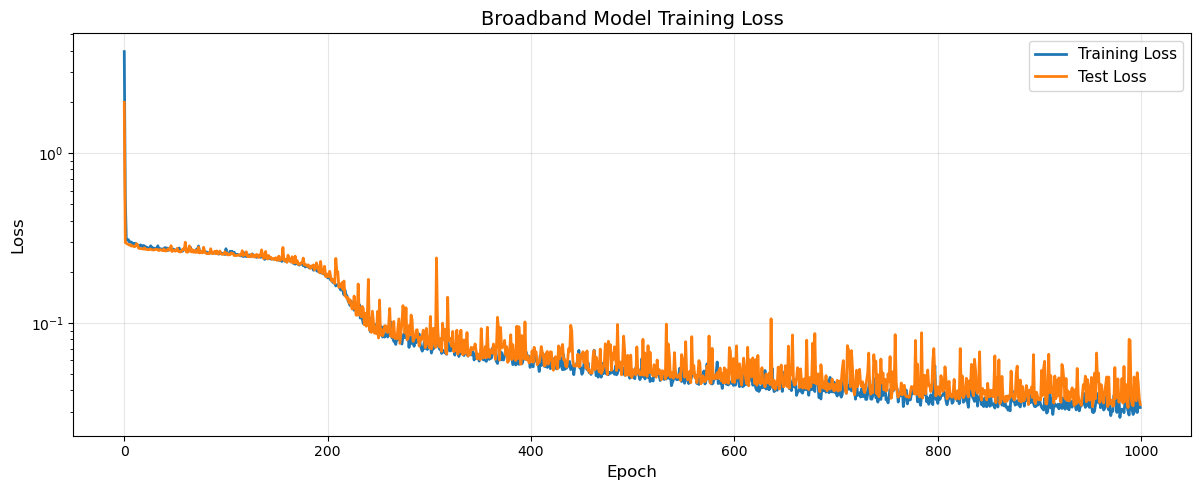

In [8]:
fig = plot_loss_curve(
    history.train_losses,
    history.test_losses,
    title="Broadband Model Training Loss"
)
plt.yscale('log')
plt.show()

## 7. Model Diagnostics

Analyze model performance with outlier diagnostic plots for each band.

In [9]:
# Gather full train and test data
X_train, y_train, _, meta_train = gather_full_data(train_loader)
X_test, y_test, _, meta_test = gather_full_data(test_loader)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1351, 6)
Test data shape: (580, 6)


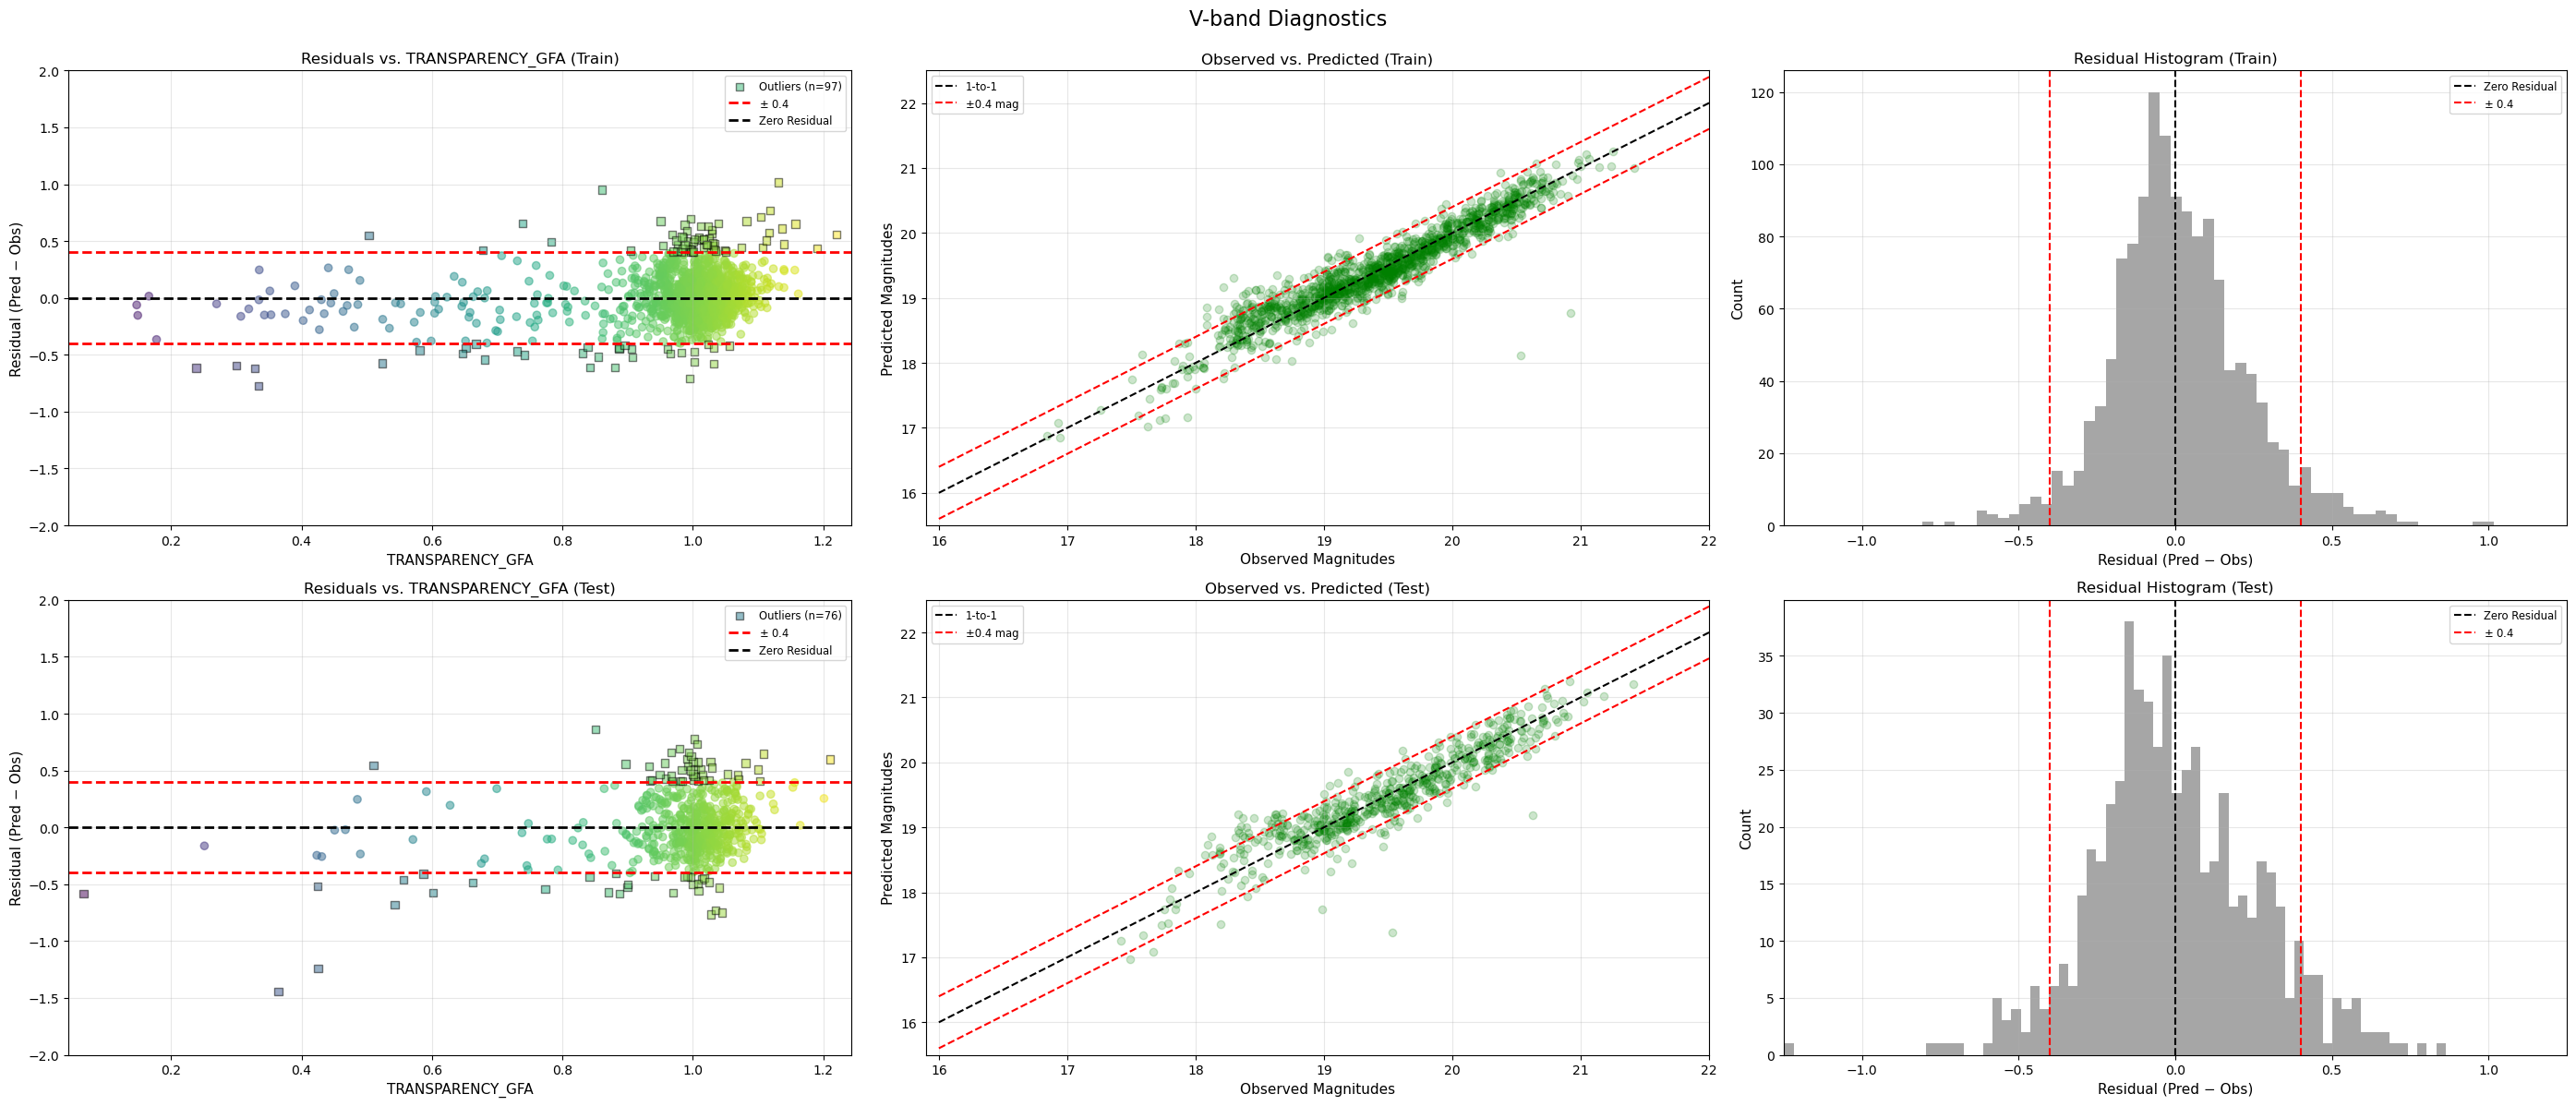

In [10]:
# Plot V-band diagnostics
fig = plot_nn_outlier_analysis(
    model,
    X_train, y_train, meta_train,
    X_test, y_test, meta_test,
    band_idx=0,  # V-band
    outlier_mag=0.40
)
plt.show()

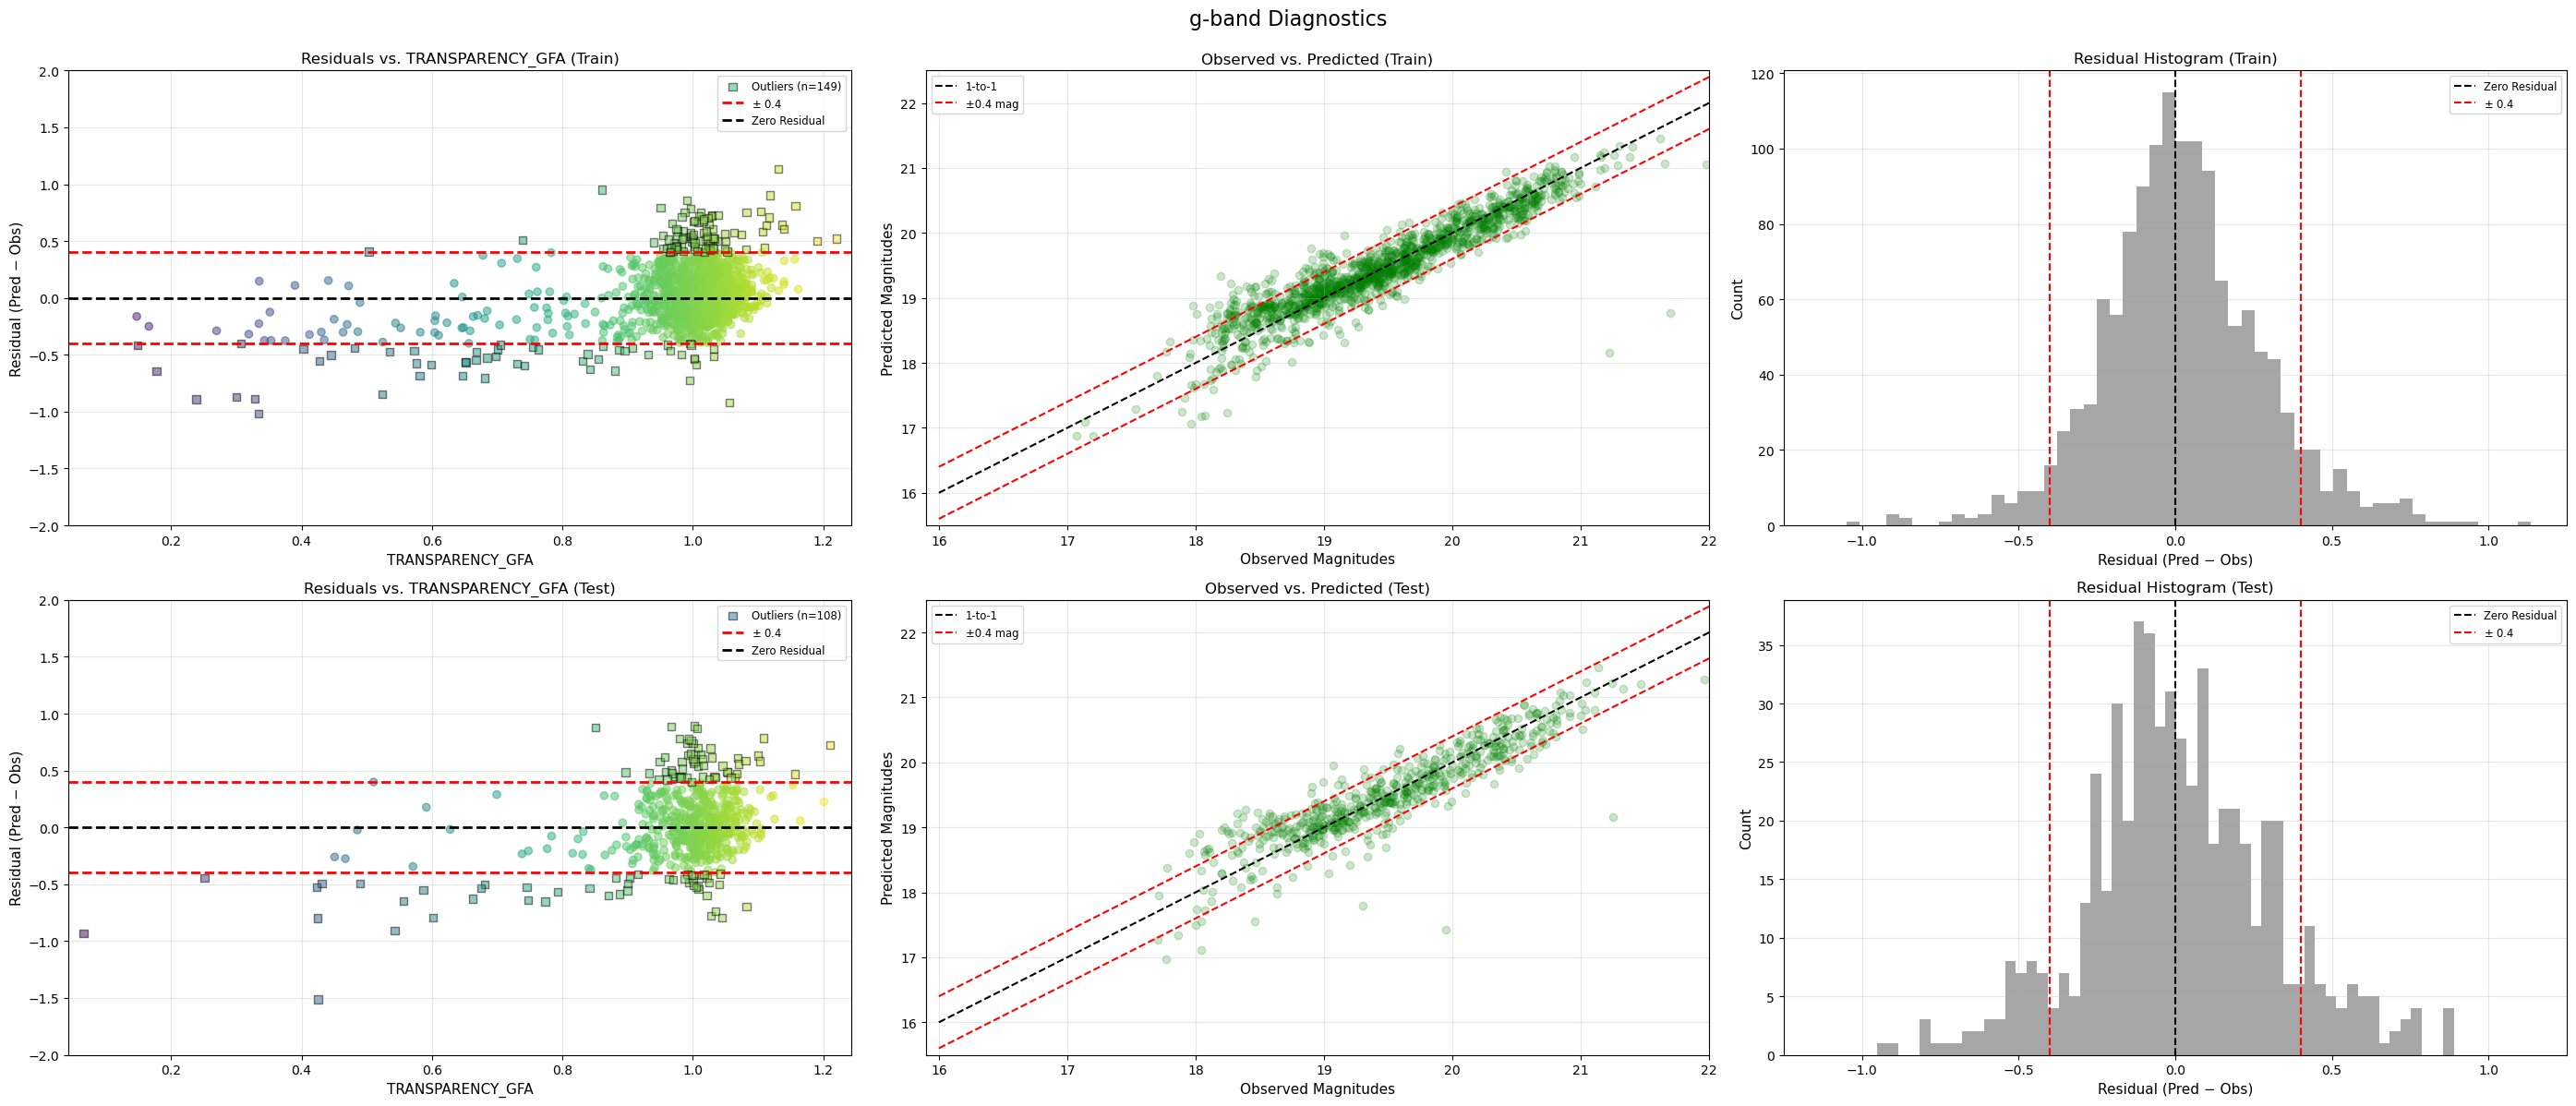

In [11]:
# Plot g-band diagnostics
fig = plot_nn_outlier_analysis(
    model,
    X_train, y_train, meta_train,
    X_test, y_test, meta_test,
    band_idx=1,  # g-band
    outlier_mag=0.40
)
plt.show()

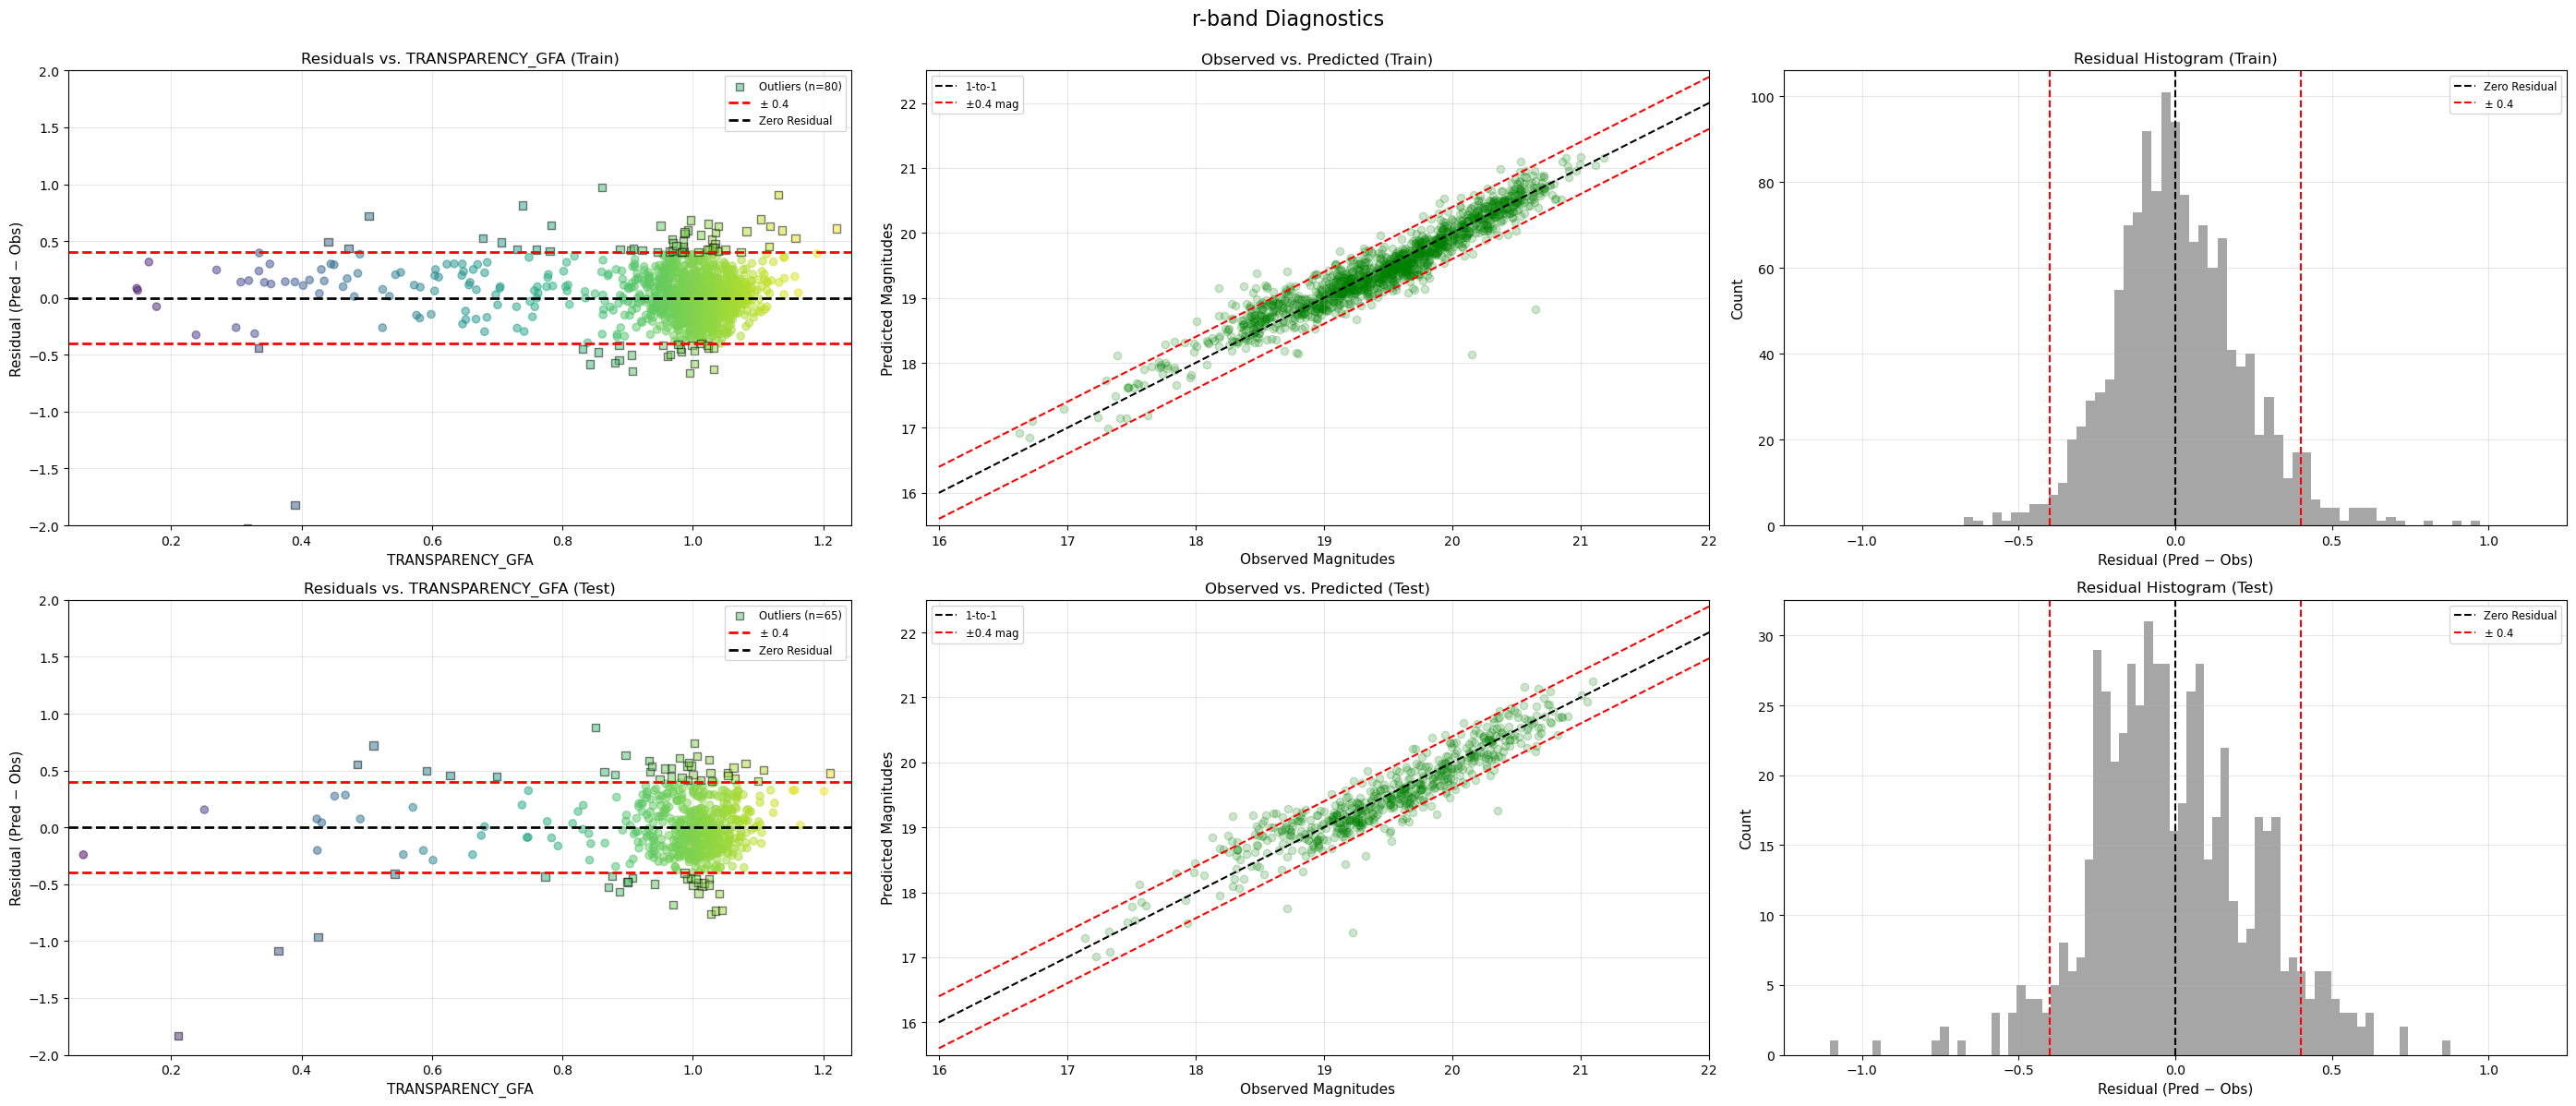

In [12]:
# Plot r-band diagnostics
fig = plot_nn_outlier_analysis(
    model,
    X_train, y_train, meta_train,
    X_test, y_test, meta_test,
    band_idx=2,  # r-band
    outlier_mag=0.40
)
plt.show()

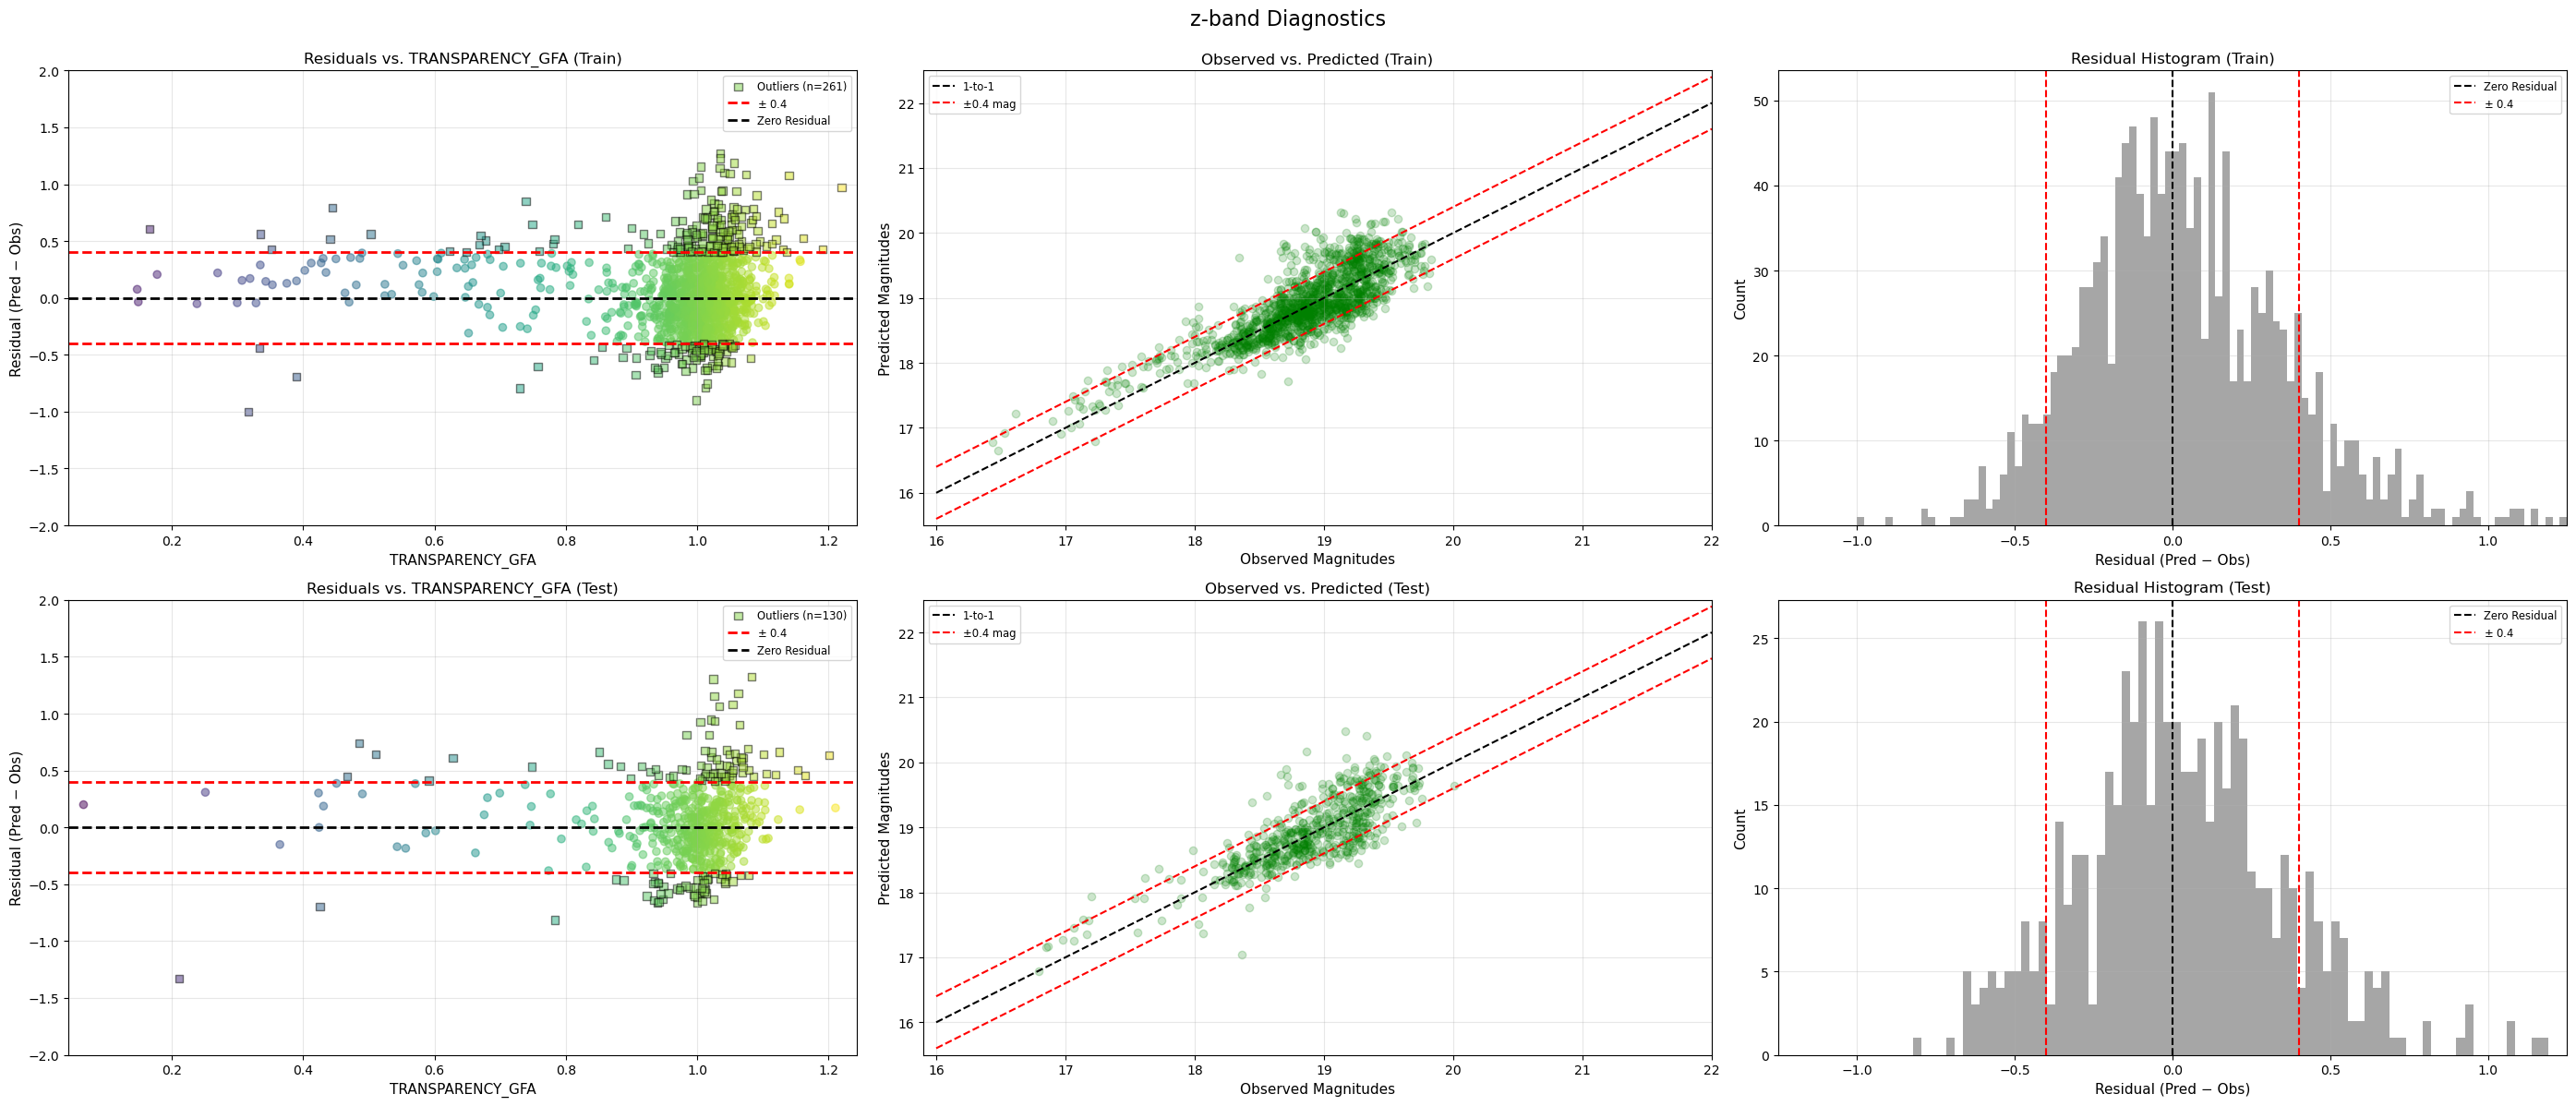

In [13]:
# Plot z-band diagnostics
fig = plot_nn_outlier_analysis(
    model,
    X_train, y_train, meta_train,
    X_test, y_test, meta_test,
    band_idx=3,  # z-band
    outlier_mag=0.40
)
plt.show()

## 8. Load Saved Model

Demonstrate how to load the best saved checkpoint.

In [14]:
# Load the saved model
from desisky.io import load_model, get_user_model_dir
from pathlib import Path

checkpoint_path = get_user_model_dir("broadband") / f"{config.run_name}.eqx"
print(f"Loading checkpoint from: {checkpoint_path}")

loaded_model, loaded_meta = load_model("broadband", path=checkpoint_path)

print("\nLoaded model metadata:")
print(f"  Epoch: {loaded_meta['training']['epoch']}")
print(f"  Test loss: {loaded_meta['training']['test_loss']:.6f}")
print(f"  Per-band RMSE: {loaded_meta['training']['per_band_rmse']}")

Loading checkpoint from: /home/mdowicz/.cache/desisky/saved_models/broadband/broadband_moon_v1.eqx

Loaded model metadata:
  Epoch: 987
  Test loss: 0.031711
  Per-band RMSE: {'V': 0.2790115773677826, 'g': 0.33295097947120667, 'r': 0.26013612747192383, 'z': 0.326521635055542}
